In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from sklearn.metrics.pairwise import euclidean_distances
import math
from scipy.spatial import ConvexHull
import torch
import itertools

def plot_triangulation (points, triang):
    plt.triplot (points[:,0], points[:,1], triang)
    plt.plot (points[:,0], points[:,1], 'o')
    plt.show()

def calc_L (points, simplices):
    #simplices = Delaunay (points).simplices
    #distances = euclidean_distances (points, points)
    
    L = torch.zeros((len(points), len(points)))

    for sim in simplices:
        for ind in [[0, 1], [1, 2], [0, 2]]:
            #L [sim [ind [0]], sim [ind [1]]] = distances [sim [ind [0]], sim [ind [1]]]
            #L [sim [ind [1]], sim [ind [0]]] = distances [sim [ind [1]], sim [ind [0]]]
            L [sim [ind [0]], sim [ind [1]]] = ((points[sim [ind [0]]][0]-points[sim [ind [1]]][0])**2+\
                                               (points[sim [ind [0]]][1]-points[sim [ind [1]]][1])**2)**0.5
            L [sim [ind [1]], sim [ind [0]]] = ((points[sim [ind [0]]][0]-points[sim [ind [1]]][0])**2+\
                                               (points[sim [ind [0]]][1]-points[sim [ind [1]]][1])**2)**0.5

    return L

def calc_triangle_area (L, i1, i2, i3):
    l1 = L [i1, i2]
    l2 = L [i2, i3]
    l3 = L [i3, i1]

    p = (l1 + l2 + l3) / 2

    return math.sqrt (p * (p - l1) * (p - l2) * (p - l3))

def calc_A (simplices, L, points_num):
    A = torch.zeros ((points_num, points_num))
    
    for i in range (points_num):
        area = 0
        
        for j in range (len (simplices)):
            if (i in simplices [j]):
                sim = simplices [j]
                
                area_part = calc_triangle_area (L, sim [0], sim [1], sim [2])
                
                area += area_part / 3
        
        A [i, i] = area
    
    return A

def find_E_Eb (points, simplices):
    E = []
    
    for sim in simplices:
        E.append (sorted ((sim [0], sim [1])))
        E.append (sorted ((sim [1], sim [2])))
        E.append (sorted ((sim [2], sim [0])))
    
    E_b = []
    hull = ConvexHull (points).vertices
    
    for i in range (len (hull) - 1):
        E_b.append (sorted ((hull [i], hull [i + 1])))
    
    E_b.append (sorted ((hull [0], hull [-1])))
    
    #АЛАРМА
    #Тут нужно оставить в E и E_b только уникальные таплы.
    #Я попробовал это сделать, но с unhashable type какая-то морока, так то я забил.
    #В этом месте числа внутри тапла отсортированы.
    #Пробовал вот таким образом:
    #return list (set (E)), list (set (E_b))
    
    return E, E_b

def calc_W (E, E_b, A, L, simplices):
    W = torch.zeros (A.shape)
    
    sh = W.shape
    
    for i in range (sh [0]):
        for j in range (i + 1, sh [0]):
            kh_list = []
    
            for sim in simplices:
                elem = set (sim)                
                ele = set ([i, j])
                
                #print ("ele, elem")
                #print (ele, elem)
                
                if (ele.issubset (elem)):
                    kh_list.append (elem.difference (ele))
            
            if (len (kh_list) == 0):
                continue
            
            h = list (kh_list [0]) [0]
            
            if ([i, j] in E and [i, j] not in E_b):
                k = list (kh_list [1]) [0]
                
                val = 0
                
                val += (- L [i, j]**2 + L [j, k]**2 + L [k, i]**2) / \
                    (8 * calc_triangle_area (L, i, j, k))

                val += (- L [i, j]**2 + L [j, h]**2 + L [h, i]**2) / \
                    (8 * calc_triangle_area (L, i, j, h))
                
                W [i, j] = val
                
            elif ([i, j] in E_b):
                val = 0
                
                val += (- L [i, j]**2 + L [j, h]**2 + L [h, i]**2) / \
                    (8 * calc_triangle_area (L, i, j, h))
                
                W [i, j] = val
        
    for i in range (sh [0]):
        for j in range (i, sh [0]):
            W [j] [i] = W [i] [j]
    
    for i in range (sh [0]):
        W [i, i] = - sum (W [i, :])

    return W

def find_eig (A):
    n, m = A.shape

    #Q = np.eye(n)
    #R = A.astype(np.float64).copy()
    
    Q = torch.eye (n)
    R = A.clone ()
    
    for i in range(m):
        x = R[i:, i].clone()
        
        #u = x[:, np.newaxis]
        u = x.unsqueeze (1)
        
        #alpha = np.linalg.norm(u)
        alpha = u.detach().numpy()
        
        u[0] -= alpha
        v = u / np.linalg.norm(u)
        
        H = np.eye(n - i) - 2 * v.dot(v.conj().T)
        
        H = np.concatenate([np.zeros([n - i, i]), H], axis=1)
        H = np.concatenate([np.eye(i, n), H], axis=0)

        R = H.dot(R)
        Q = Q.dot(H)

    #return Q[:, :m], R[:m]
    
    eigs = []
    
    for i in range (n):
        eigs.append (R [i, i])
    
    return eigs

def modified_gram_schmidt_qr(A): # 5 pts
    Q = torch.zeros((A.shape[0], A.shape[1])) #saaas
    R = torch.zeros((A.shape[1], A.shape[1]))
    
    #initialization
    Q[:, :A.shape[1]] = A[:, :A.shape[1]].clone()
    
    #Q building with G-S ortagonalization
    for i in range(A.shape[1]):
        for j in range(i):
            Q[:, i] = Q[:, i].clone()-Q[:, i].clone() @ Q[:, j].clone()*Q[:, j].clone()
        shit1 = torch.norm(Q[:, i]).clone()
        shit2 = Q[:, i].clone()/shit1
        Q[:, i] = shit2.clone()
    
    #R building
    for i in range(A.shape[1]):
        for j in range(i+1):
            R[j, i] = Q[:, j].clone() @(A[:, i]).clone()
    
    return Q, R

def modified_gram_schmidt_qr_(A): # 5 pts
    assert A.shape[0] >= A.shape[1], 'm is not >= n'
    new_vectors = torch.zeros(A.shape)
    for i in range(A.shape[1]):
        new_vectors[:,i] += A[:,i]
        if i > 0:
            new_vectors[:,i] -= torch.tensor(((A[:,i] @ new_vectors[:,0])/(new_vectors[:,0] @ new_vectors[:,0])) * new_vectors[:,0])
        
        for j in range(1,i):
            new_vectors[:,i] -= torch.tensor(((new_vectors[:,i] @ new_vectors[:,j])/(new_vectors[:,j] @ new_vectors[:,j])) * new_vectors[:,j])
        
    # normalization
    for i in range(new_vectors.shape[1]):
        new_vectors[:,i] /= torch.tensor(new_vectors[:,i]).norm()
    Q = new_vectors
    R = torch.zeros((A.shape[1],A.shape[1]))
    for i in range(A.shape[1]):
        for j in range(i, A.shape[1]):
            R[i,j] += A[:,j] @ new_vectors[:,i]
    return Q, R

def find_eigenvalues (W, A):
    product = torch.inverse(a) @ \
W
    #lambdas, vectors = tuple (torch.symeig (product, eigenvectors=True))
    #lambdas, vectors = tuple (torch.eig (product, eigenvectors=True))

    Q, R = modified_gram_schmidt_qr_ (product)
    
    eigen = torch.diag(R)
    #eigen[-1]=0
    
    return eigen#, vectors

def cut (val):
    return (min (0, val))**2

def rho (V, L, E_b, simplices):
    rho_1 = 0
    
    for e in E_b:
        rho_1 += L [e [0], e [1]]**2
    
    rho_2 = 0
    
    for s in simplices:
        for sim in list(itertools.permutations(s)):

            rot_matr = torch.tensor ([[0., -1.], [1., 0.]])
            sub_1 = V [sim [1]] - V [sim [0]]
            sub_2 = V [sim [2]] - V [sim [0]]

            curr_val = (rot_matr @ sub_1).transpose(0, -1) @ sub_2

            rho_2 += curr_val
    
    rho = rho_1 + cut (rho_2)
    
    return rho

def weighted_norm (a, b):
    norm = 0
    
    for i in range (len (a)):
        norm += (a [i] - b [i])**2 / (i + 1)
    
    return norm

initial = [(0.0, 0.0), (1.0, 0.0), (2.0, 1.0), (0.0, 2.0)]
points = torch.tensor(initial, requires_grad=True)

#points = np.array([[0, 0], [1, 0], [2, 0], [0, 2]])
    
#points = np.random.rand (6, 2)

print (points)

tri = Delaunay (initial)
simplices = tri.simplices

L = calc_L (points, simplices)
#print (L)

A = calc_A (simplices, L, len (points))

#print (A)

E, E_b = find_E_Eb (initial, simplices)

#print (E)
#print ("\n")
#print (E_b)

W = calc_W (E, E_b, A, L, simplices)

print (W)

pen = rho (points, L, E_b, simplices)

print (pen)

#plot_triangulation (points, simplices)

tensor([[0., 0.],
        [1., 0.],
        [2., 1.],
        [0., 2.]], requires_grad=True)
tensor([[-1.2500,  1.0000,  0.0000,  0.2500],
        [ 1.0000, -1.8333,  0.6667,  0.1667],
        [ 0.0000,  0.6667, -0.8333,  0.1667],
        [ 0.2500,  0.1667,  0.1667, -0.5833]], grad_fn=<CopySlices>)
tensor(12., grad_fn=<AddBackward0>)


In [281]:
product = torch.inverse (A) @ W
    
    #lambdas, vectors = tuple (torch.symeig (product, eigenvectors=True))
    #lambdas, vectors = tuple (torch.eig (product, eigenvectors=True))

Q, R = modified_gram_schmidt_qr (product)

In [282]:
torch.diag(R)

tensor([ 3.9487,  1.8415,  0.8187, -0.7330], grad_fn=<DiagBackward>)

In [283]:
torch.qr(product)

(tensor([[-0.9497, -0.1771, -0.0572,  0.2520],
         [ 0.3039, -0.6167, -0.3613,  0.6299],
         [ 0.0000,  0.7241, -0.5770,  0.3780],
         [ 0.0760,  0.2531,  0.7303,  0.6299]], grad_fn=<QrBackward>),
 tensor([[ 3.9487e+00, -3.5024e+00,  2.5831e-01, -7.0466e-01],
         [ 0.0000e+00,  1.8415e+00, -1.6495e+00, -1.9198e-01],
         [ 0.0000e+00,  0.0000e+00,  8.1867e-01, -8.1867e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.3842e-07]],
        grad_fn=<QrBackward>))

In [284]:
initial = [(0.0, 0.0), (1.0, 0.0), (2.0, 1.0), (0.0, 2.0)]

#initial = torch.rand (15, 2)

target = torch.tensor(initial)
tri = Delaunay (initial)
simplices = tri.simplices
E, E_b = find_E_Eb (initial, simplices)
L = calc_L (target, simplices)
A = calc_A (simplices, L, len (points))
W = calc_W (E, E_b, A, L, simplices)
mu = find_eigenvalues(W, A)
print (E, E_b)

RuntimeError: _th_getri_single is not implemented for type torch.LongTensor

In [279]:
#initial = [(0.0, 0.0), (1.0, 0.0), (1.0, 1.0), (0.0, 1.0)]

initial = [(0.0, 0.0), (1.0, 0.0), (2.0, 1.0), (0.0, 2.1)]

#initial = torch.rand (15, 2)

#initial = [(0.0, 0.0), (1.0, 0.0), (2.0, 1.5)]

points = torch.tensor(initial, requires_grad=True)
optimizer = torch.optim.Adam([points], lr = 0.001)
tri = Delaunay (initial)
simplices = tri.simplices
E, E_b = find_E_Eb (initial, simplices)

for _ in range (1000):
    L = calc_L (points, simplices)
    A = calc_A (simplices, L, len (points))
    W = calc_W (E, E_b, A, L, simplices)
    pen = rho (points, L, E_b, simplices)
    
    current_eigen = find_eigenvalues(W, A)
    
    #loss =   weighted_norm(current_eigen, mu)+pen# calculate loss
    loss =   weighted_norm(current_eigen, mu)+pen# calculate loss
    #print (mu)
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients of all variables wrt loss

    optimizer.step()
    #print (current_eigen)
    print (loss)

/home/kefir/miniconda3/envs/zenv/lib/python3.7/site-packages/ipykernel_launcher.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/kefir/miniconda3/envs/zenv/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/kefir/miniconda3/envs/zenv/lib/python3.7/site-packages/ipykernel_launcher.py:212: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(23700.9727, grad_fn=<AddBackward0>)
tensor(23688.1543, grad_fn=<AddBackward0>)
tensor(23698.7676, grad_fn=<AddBackward0>)
tensor(23645.4551, grad_fn=<AddBackward0>)
tensor(23629.1230, grad_fn=<AddBackward0>)
tensor(23617.7246, grad_fn=<AddBackward0>)
tensor(23632.9277, grad_fn=<AddBackward0>)
tensor(23715.7422, grad_fn=<AddBackward0>)
tensor(23685.4824, grad_fn=<AddBackward0>)
tensor(23639.2773, grad_fn=<AddBackward0>)
tensor(23636.9805, grad_fn=<AddBackward0>)
tensor(23670.9531, grad_fn=<AddBackward0>)
tensor(23638.9297, grad_fn=<AddBackward0>)
tensor(23726.6504, grad_fn=<AddBackward0>)
tensor(23706.2148, grad_fn=<AddBackward0>)
tensor(23725.0586, grad_fn=<AddBackward0>)
tensor(23732.3340, grad_fn=<AddBackward0>)
tensor(23642.6895, grad_fn=<AddBackward0>)
tensor(23634.3027, grad_fn=<AddBackward0>)
tensor(23672.5508, grad_fn=<AddBackward0>)
tensor(23694.8945, grad_fn=<AddBackward0>)
tensor(23718.0254, grad_fn=<AddBackward0>)
tensor(23683.6582, grad_fn=<AddBackward0>)
tensor(2366

tensor(23914.5020, grad_fn=<AddBackward0>)
tensor(23800.8203, grad_fn=<AddBackward0>)
tensor(23880.5176, grad_fn=<AddBackward0>)
tensor(23832.5879, grad_fn=<AddBackward0>)
tensor(23854.6367, grad_fn=<AddBackward0>)
tensor(23907.7188, grad_fn=<AddBackward0>)
tensor(23829.2715, grad_fn=<AddBackward0>)
tensor(23807.3613, grad_fn=<AddBackward0>)
tensor(23872.8848, grad_fn=<AddBackward0>)
tensor(23913.8730, grad_fn=<AddBackward0>)
tensor(23914.3066, grad_fn=<AddBackward0>)
tensor(23819.9336, grad_fn=<AddBackward0>)
tensor(23910.4121, grad_fn=<AddBackward0>)
tensor(23923.9609, grad_fn=<AddBackward0>)
tensor(23912.8555, grad_fn=<AddBackward0>)
tensor(23875.7500, grad_fn=<AddBackward0>)
tensor(23859.3555, grad_fn=<AddBackward0>)
tensor(23816.6621, grad_fn=<AddBackward0>)
tensor(23890.7441, grad_fn=<AddBackward0>)
tensor(23827.8477, grad_fn=<AddBackward0>)
tensor(23865.9277, grad_fn=<AddBackward0>)
tensor(23881.6641, grad_fn=<AddBackward0>)
tensor(23922.3945, grad_fn=<AddBackward0>)
tensor(2390

tensor(23911.8262, grad_fn=<AddBackward0>)
tensor(24009.3223, grad_fn=<AddBackward0>)
tensor(23926.4141, grad_fn=<AddBackward0>)
tensor(23923.4004, grad_fn=<AddBackward0>)
tensor(23904.1445, grad_fn=<AddBackward0>)
tensor(23889.0254, grad_fn=<AddBackward0>)
tensor(23939.8594, grad_fn=<AddBackward0>)
tensor(23952.5176, grad_fn=<AddBackward0>)
tensor(23930.6660, grad_fn=<AddBackward0>)
tensor(24007.2715, grad_fn=<AddBackward0>)
tensor(23896.5664, grad_fn=<AddBackward0>)
tensor(23881.5371, grad_fn=<AddBackward0>)
tensor(23949.4824, grad_fn=<AddBackward0>)
tensor(23902.6895, grad_fn=<AddBackward0>)
tensor(23916.9492, grad_fn=<AddBackward0>)
tensor(23889.7812, grad_fn=<AddBackward0>)
tensor(23918.9922, grad_fn=<AddBackward0>)
tensor(23982.9531, grad_fn=<AddBackward0>)
tensor(23952.1191, grad_fn=<AddBackward0>)
tensor(23950.0488, grad_fn=<AddBackward0>)
tensor(23893.8145, grad_fn=<AddBackward0>)
tensor(24029.4902, grad_fn=<AddBackward0>)
tensor(23930.3516, grad_fn=<AddBackward0>)
tensor(2399

tensor(24082.2598, grad_fn=<AddBackward0>)
tensor(23990.8633, grad_fn=<AddBackward0>)
tensor(23985.9883, grad_fn=<AddBackward0>)
tensor(23960.5801, grad_fn=<AddBackward0>)
tensor(23946.3906, grad_fn=<AddBackward0>)
tensor(24048.9297, grad_fn=<AddBackward0>)
tensor(24016.5527, grad_fn=<AddBackward0>)
tensor(23975.6562, grad_fn=<AddBackward0>)
tensor(23999.8379, grad_fn=<AddBackward0>)
tensor(24086.7070, grad_fn=<AddBackward0>)
tensor(24029.2891, grad_fn=<AddBackward0>)
tensor(24053.8438, grad_fn=<AddBackward0>)
tensor(24022.1191, grad_fn=<AddBackward0>)
tensor(24050.3633, grad_fn=<AddBackward0>)
tensor(23925.1992, grad_fn=<AddBackward0>)
tensor(24079.8086, grad_fn=<AddBackward0>)
tensor(24055.8281, grad_fn=<AddBackward0>)
tensor(23997.8438, grad_fn=<AddBackward0>)
tensor(24002.3926, grad_fn=<AddBackward0>)
tensor(24028.2109, grad_fn=<AddBackward0>)
tensor(23953.5664, grad_fn=<AddBackward0>)
tensor(24065.2539, grad_fn=<AddBackward0>)
tensor(23928.0859, grad_fn=<AddBackward0>)
tensor(2405

tensor(23955.4902, grad_fn=<AddBackward0>)
tensor(23960.1133, grad_fn=<AddBackward0>)
tensor(24001.9453, grad_fn=<AddBackward0>)
tensor(23977.4355, grad_fn=<AddBackward0>)
tensor(24150.3652, grad_fn=<AddBackward0>)
tensor(24033.3750, grad_fn=<AddBackward0>)
tensor(24096.2227, grad_fn=<AddBackward0>)
tensor(23953.1230, grad_fn=<AddBackward0>)
tensor(23952.5293, grad_fn=<AddBackward0>)
tensor(23990.2305, grad_fn=<AddBackward0>)
tensor(24150.0312, grad_fn=<AddBackward0>)
tensor(24142.2070, grad_fn=<AddBackward0>)
tensor(24069.4375, grad_fn=<AddBackward0>)
tensor(24127.6035, grad_fn=<AddBackward0>)
tensor(23986.1133, grad_fn=<AddBackward0>)
tensor(24069.8672, grad_fn=<AddBackward0>)
tensor(24097.3809, grad_fn=<AddBackward0>)
tensor(24041.3223, grad_fn=<AddBackward0>)
tensor(23980.4980, grad_fn=<AddBackward0>)
tensor(24014.3125, grad_fn=<AddBackward0>)
tensor(24000.0625, grad_fn=<AddBackward0>)
tensor(24161.4434, grad_fn=<AddBackward0>)
tensor(24078.4492, grad_fn=<AddBackward0>)
tensor(2410

tensor(24193.9863, grad_fn=<AddBackward0>)
tensor(24007.8828, grad_fn=<AddBackward0>)
tensor(24165.4160, grad_fn=<AddBackward0>)
tensor(23984.4102, grad_fn=<AddBackward0>)
tensor(23954.4883, grad_fn=<AddBackward0>)
tensor(24192.7812, grad_fn=<AddBackward0>)
tensor(23996.6465, grad_fn=<AddBackward0>)
tensor(24199.8848, grad_fn=<AddBackward0>)
tensor(24008.8984, grad_fn=<AddBackward0>)
tensor(24154.1191, grad_fn=<AddBackward0>)
tensor(24176.5410, grad_fn=<AddBackward0>)
tensor(24169.6895, grad_fn=<AddBackward0>)
tensor(24097.5215, grad_fn=<AddBackward0>)
tensor(24003.3164, grad_fn=<AddBackward0>)
tensor(24195.5078, grad_fn=<AddBackward0>)
tensor(24060.3574, grad_fn=<AddBackward0>)
tensor(24110.7129, grad_fn=<AddBackward0>)
tensor(23983.1875, grad_fn=<AddBackward0>)
tensor(23981.8301, grad_fn=<AddBackward0>)
tensor(24194.2266, grad_fn=<AddBackward0>)
tensor(24100.0781, grad_fn=<AddBackward0>)
tensor(24152.6953, grad_fn=<AddBackward0>)
tensor(24039.8477, grad_fn=<AddBackward0>)
tensor(2395

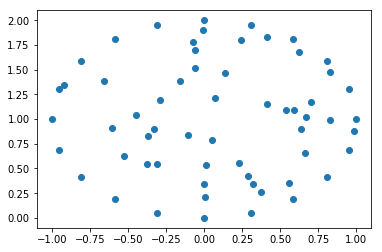

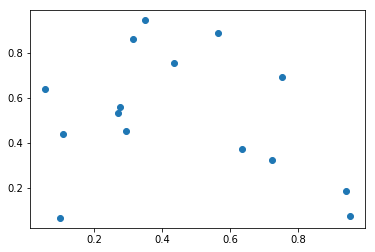

In [20]:
def plot_mesh (mesh):
    plt.plot (mesh [:, 0], mesh [:, 1], 'o')
    plt.show()

def generate_circle (x, y, r, num, num_interior=0):
    circle = np.zeros ((num + num_interior, 2), np.float64)
    
    for i in range (num):
        angle = math.pi * 2 / num * i
        
        circle [i, 0] = x + r * math.cos (angle)
        circle [i, 1] = y + r * math.sin (angle)
    
    for i in range (num_interior):
        px = 0
        py = 0
        
        while (True):
            px = np.random.rand (1)
            py = np.random.rand (1)
            
            if ((px - 0.5)**2 + (py - 0.5)**2 < 0.25):
                break
        
        px = x + px * 2 * r - r
        py = y + py * 2 * r - r
        
        circle [num + i, 0] = px
        circle [num + i, 1] = py

    return circle

def generate_random_mesh (num):
    mesh = np.random.rand (num, 2)
    
    return mesh

circle = generate_circle (0, 1, 1, 20, num_interior=40)
plot_mesh (circle)

rand_mesh = generate_random_mesh (15)
plot_mesh (rand_mesh)

#Немного о том, почему функция генерации кружочка именно такая.
#В ней отдельно задается количество внешних точек и отдельно количество внутренних.
#Это нужно, чтобы после генерации рандомного меша получить количество граничных точек
#в нем и создать кружочек с таким же количеством граничных точек. Это будет означать,
#что количество граничных ребер в множествах тоже совпадает. Насколько я понимаю, это
#необходимо, потому что если рандомный меш состоит из четырех точек - треугольника и
#одной внутренней, то приближать его, начиная с квадрата, было бы странно.